## Описание проекта и цели исследования

В нашем распоряжении есть список гипотез для увеличения выручки и данные, собранные в ходе проведения A/B теста. Задачей исследования будет приоритезация гипотез и анализ результатов A/B теста. По результатам необходимо принять одно из решений: 
1. Остановить тест, зафиксировать победу одной из групп. 
2. Остановить тест, зафиксировать отсутствие различий между группами. 
3. Продолжить тест.

Гипотезы по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort храняться в файле hypothesis.csv. Для выполнения целей исследования в части приоритезации гипотез применим фреймворки ICE и RICE, изучим различие в приоритетах.

Результаты A/B-теста записаны в файлах orders.csv и visitors.csv.

В ходе исследования построим графики кумулятивных показателей, интерпретируем их. Поищем выбросы в данных, выберем границу для определения аномальных пользователей. Посчитаем статистическую значимость различий в  конверсии и среднем чеке заказа между группами по «сырым» данным. Повторим расчеты статистической значимости различий в конверсии и среднем чеке между группами по «очищенным» данным. Сделаем выводы и примем решение по результатам теста.

## Загрузка и предобработка данных

In [5]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
# конвертеры, которые позволяют использовать типы pandas в matplotlib 
register_matplotlib_converters()

#pd.set_option("max_colwidth", 90)
pd.set_option('display.max_colwidth', 150)

In [6]:
# загружаем данные

hypothesis = pd.read_csv('*')
visitors = pd.read_csv('*')
orders = pd.read_csv('*')


In [7]:
# Функция для предварительного ознакомления с данными. 

def hello_data(data):
    
    ''' Выводит первые строки, 
                info, 
                уникальные значения
                и пропуски, если они есть '''
    
    columns = data.columns 
    display(data.head(10))
    display(data.info())
    lost_values = data.duplicated().sum()
   
    print(
        f'Явных дубликатов в данных: {lost_values}. Это {lost_values / len(data) * 100:.2f}% от всех значений.'
         )
    print()
        
    for column in columns: # для каждой колонки
        try:
            unique_value = (len(data[column].unique())) # считаем уникальные значения 
        except AssertionError:
            pass
        
        if data[column].isna().sum() != 0: # если в колонке есть пропуски
            print( f'Уникальных значений в колонке {column} - {unique_value}') #выводим количество уникальных значений
            persent = (data[column].isna().sum() / len(data[column]) * 100) # считаем сколько это в процентах и округляем методом "round"
            print('Пропущенных строк в колонке {} - {:.1f} %'.format(column, persent))
            print("_"*20)
        else: print( f'Уникальных значений в колонке {column} - {unique_value}') # если пропусков не нашли, то выводим количество уникальных значений  

hello_data(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

Явных дубликатов в данных: 0. Это 0.00% от всех значений.

Уникальных значений в колонке Hypothesis - 9
Уникальных значений в колонке Reach - 6
Уникальных значений в колонке Impact - 7
Уникальных значений в колонке Confidence - 7
Уникальных значений в колонке Efforts - 6


Проблем в данных нет, но колонки хорошо бы привести к нижнему регистру. Смотрим на следующую табицу.

In [8]:
# смотрим общую информацию а датасете "orders" 
hello_data(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

Явных дубликатов в данных: 0. Это 0.00% от всех значений.

Уникальных значений в колонке transactionId - 1197
Уникальных значений в колонке visitorId - 1031
Уникальных значений в колонке date - 31
Уникальных значений в колонке revenue - 713
Уникальных значений в колонке group - 2


Здесь тоже проблем в данных нет, но нужно привести колонку date к типу datetime. Ну и смотрим третью таблицу.

In [9]:
# смотрим общую информацию а датасете "visitors" 
hello_data(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Явных дубликатов в данных: 0. Это 0.00% от всех значений.

Уникальных значений в колонке date - 31
Уникальных значений в колонке group - 2
Уникальных значений в колонке visitors - 58


Во всех трех таблицах проблем  в данных не обнаружено, но для дальнейшей работы необходимо привести значения колонок "date" к типу datetime и обработаем также названия колонок.

In [10]:
#приводим название колонок hypothesis к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()

In [11]:
# переименовываем колонки для удобства работы
orders = orders.rename(columns = {'transactionId' : 'orderId', 'visitorId': 'userId'})
orders.head()

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Проверим есть ли у нас пересечение пользователей между группами.

In [12]:
# отбираем группы из данных с заказами 
group_a = orders.query('group == "A"') 
group_b = orders.query('group == "B"') 
  
# получаем пользователей, попавших в обе группы с помощью "intersect1d",
# он возвращает отсортированные уникальные значения, которые находятся в обоих входных массивах.
group_a_and_b = list(np.intersect1d(group_a['userId'], group_b['userId']))
display('В обе группы попало - {0} пользователей'.format(len(group_a_and_b)))

'В обе группы попало - 58 пользователей'

In [13]:
# считаем сколько это в процентах от всех пользователей
persent = round(len(group_a_and_b) / len(orders) * 100, 2)

display('Пересечение в группах - {0}%'.format(persent))

'Пересечение в группах - 4.85%'

Нашли 58 пользователей, которые попали в обе группы теста. Их  менее 5% от общего числа. Стоило бы, конечно, удалить этих пользователей из наших двух таблиц с визитами и заказами, но таблица визитов не содержит id пользоватлей, только их количество.  Если мы уберем только совершенные ими заказы, то расчеты конверсии будут не верными. Поэтому оставляем как есть, но стоит разобраться с настройками при проведении теста и выяснить причину.

In [41]:
# переводим тип данных в datetime
visitors['date'] = pd.to_datetime(visitors['date']).dt.date 
orders['date'] = pd.to_datetime(orders['date']).dt.date 
# смотрим минимальную и максимальную дату
display('В таблице "orders" начальная дата {}, конечная дата {}'.format(orders['date'].min(), orders['date'].max()))
display('В таблице "visitors" начальная дата {}, конечная дата {}'.format(visitors['date'].min(), visitors['date'].max()))

'В таблице "orders" начальная дата 2019-08-01, конечная дата 2019-08-31'

'В таблице "visitors" начальная дата 2019-08-01, конечная дата 2019-08-31'

### Вывод 

Данные загружены и проверены. Проблем в выгрузке данных нет. Но нашли пользователей, которые попали в обе группы теста. Так как их менее 5% и нет возможности исключить их из таблицы Visitors, было решено оставить данные в таком виде, однако стоит выяснить причину по которой это произошло.

Также выполнено переименование колонок и заменен тип данных на дату, где это было необходимо. Проверены минимальная и максимальная дата в имеющихся таблицах "orders" и "visitors". Даты совпали, в нашем распоряжении имеются данные за 1 месяц: с 1 по 3 августа 2019 года. 

## Приоритизация гипотез.

В файле hypothesis.csv  есть данные о 9 гипотезах по увеличению выручки интернет-магазина с указанными параметрами для принятия решения:

- Reach — скольких пользователей затронет изменение, которое собираемся внести;
- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- Confidence — степерь уверенности, что это изменение повлияет на пользователей именно так;
- Efforts — сколько стоит протестировать эту гипотезу.

Используя 2 фрэймворка ICE и RICE выполним приоритезацию гипотез и посмотрим какие результаты это даст.

In [15]:
# Применимм фреймворк ICE. Отсортируем гипотезы  по убыванию приоритета.

hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 1)
hypothesis.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


In [16]:
# Применимм фреймворк RICE. Отсортируем гипотезы  по убыванию приоритета.

hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


### Вывод

Применив оба фреймворка видим, что 3 гипотезы из 4х с высоким рейтингом совпали,  но имеют разные позиции относительно друг друга. Для ICE это 8, 0, 7 и 6 гипотезы, а для RICE это 7, 2, 0 и 6 гипотезы. Эту разницу дает метод подсчета. В фрэймфорке RICE используется дополнительный параметр Reach - отражающий скольких пользователей затронут изменения. Поэтому здесь на первое место попала гипотеза 7 с высокими ipmpact и confidence, но которая затронет большинство пользователей при относительно невысокой стоимости проверки гипотезы.

## Анализ A/B-теста




### Куммулятивные показатели

Прежде чем интерпретировать результаты A/B теста стоит убедиться, что тест можно считать завершенным. Согласно центральной предельной теореме значение кумулятивных метрик часто сходится и устанавливается около некоторого среднего. Тогда по графику кумулятивных метрик, если данных достаточно для статистической значимости, можно определить, стоит останавливать тест или нет.

Построим и изучим:
- график кумулятивной выручки по группам, 
- график кумулятивного среднего чека по группам,
- график кумулятивной конверсии по группам,
- график относительного изменения кумулятивной конверсии группы B к группе A.

Чтобы построить графики, нужно собрать кумулятивные данные. Собирем их в  новый датафрейм "cumulativeData" со столбцами:
- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

Соберём "cumulativeData" в несколько действий:

In [17]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

# получаем агрегированные кумулятивные по дням данные о заказах.
#Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups, 
# а группа теста равна группе из datesGroups
ordersAggregated = datesGroups\
                  .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],\
                                                         orders['group'] == x['group'])]\
                  .agg({'date' : 'max', # Агрегируем значения. Вычислим максимальную дату. 
                        'group' : 'max', # Для группы тоже считаем максимум,делаем это, чтобы столбец 'group' не пропал из итогового вывода.
                        'orderId' : 'nunique', # Найдём число уникальных ID заказов и пользователей. 
                        'userId' : 'nunique', 
                        'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) # Подсчитаем сумму средних чеков                                                                            
                   
# смотрим 
ordersAggregated.head(10)

,date,group,orderId,userId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
310,2019-08-03,B,61,59,380996
499,2019-08-04,A,84,77,425699
498,2019-08-04,B,78,75,489567
698,2019-08-05,A,109,100,549917
699,2019-08-05,B,101,98,581995


In [18]:
# Аналогично получаем агрегированные кумулятивные по дням данные о посетителях
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
                                .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
                                .sort_values(by=['date','group'])
# смотрим что получилось
visitorsAggregated.head(10)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
310,2019-08-03,B,1803
499,2019-08-04,A,2562
498,2019-08-04,B,2573
698,2019-08-05,A,3318
699,2019-08-05,B,3280


In [19]:
# объединяем кумулятивные данные в одной таблице
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
# переименовываем столбцы
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# проверяем 
cumulativeData.tail(10)

,date,group,orders,buyers,revenue,visitors
52,2019-08-27,A,495,449,3514698,16376
53,2019-08-27,B,548,504,5232260,16523
54,2019-08-28,A,512,464,3615820,16970
55,2019-08-28,B,576,526,5328268,17177
56,2019-08-29,A,534,484,3936510,17547
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736
61,2019-08-31,B,640,586,5907760,18916


Кумулятивные данные собраны. На 31.08.2019 в эксперименте приняло участие более 37 тысяч пользователей. В  группу "А" попало 18736 пользователей, из них совершили хотя бы одну покупку 503 пользователя на общую сумму 4 084 803 д.е. В группу "B" попало 18916 пользователей, из них совершили хотя бы одну покупку 586 пользователей на общую сумму 5 907 760 д.е.

Теперь построим графики кумулятивной выручки по дням и группам A/B-тестирования:

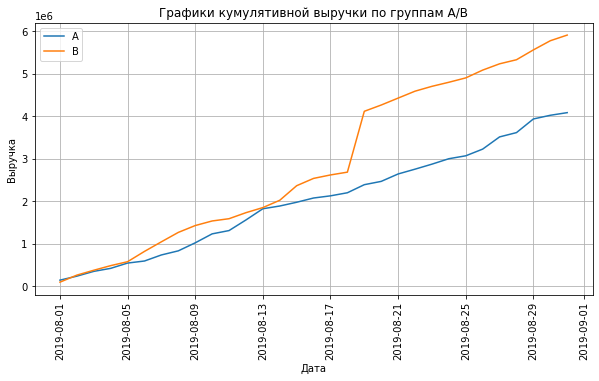

In [20]:
#Создаем датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

#Создаем датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(10,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')# Строим график выручки группы А
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B') # Строим график выручки группы B

plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.xticks(rotation=90) 
plt.title('Графики кумулятивной выручки по группам A/B')
plt.legend()
plt.grid(which='major')
plt.show()

Кумулятивная выручка увеличивается для обеих групп, как и должно быть. Для группы "B" этот показатель стабильно выше, чем у "А". 
Однако 18.08.2019 график выручки группы "B" резко вырос. На графике группы "А" тоже наблюдается небольшой пик 13.08.2019. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Такие выбросы проанализируем после изучения всех кумулятивных показателей.

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

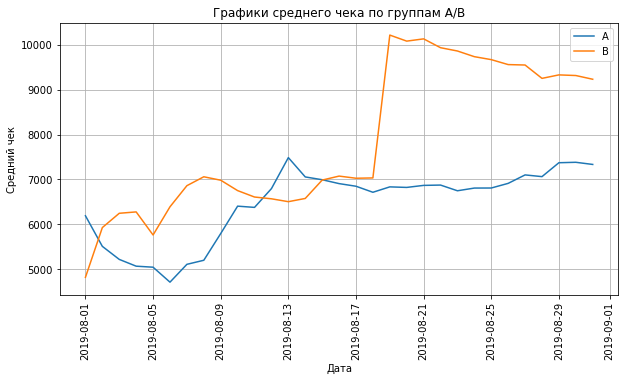

In [21]:
plt.figure(figsize=(10,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.xticks(rotation=90) 
plt.title('Графики среднего чека по группам A/B')
plt.legend()
plt.grid(which='major')
plt.show()

Снова видим всплески 13.08.2019 и 18.08.2019. Значение среднего чека "B" резко подскочило после всплеска, но уже на следующий день отмечаем тенденцию к снижению показателя. Следовательно пока нельзя окончательно доверять этому графику.

Теперь построим график относительного различия для среднего чека. 

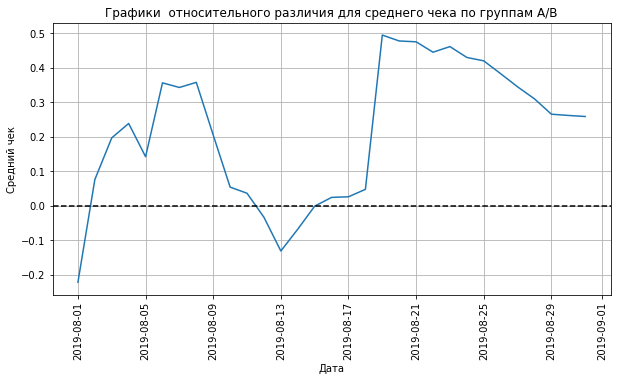

In [40]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10,5))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
                                          (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)


plt.axhline(y=0, color='black', linestyle='--') # добавляем ось X
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.xticks(rotation=90) 
plt.title('Графики  относительного различия для среднего чека по группам A/B')
plt.grid(which='major')
plt.show()

Видим резкие изменения метрики различия средних чеков между группами  A/B. Такая нестабильность также указывает на присутствие аномальных значений в данных.

Проанализируем график кумулятивной конверсии:

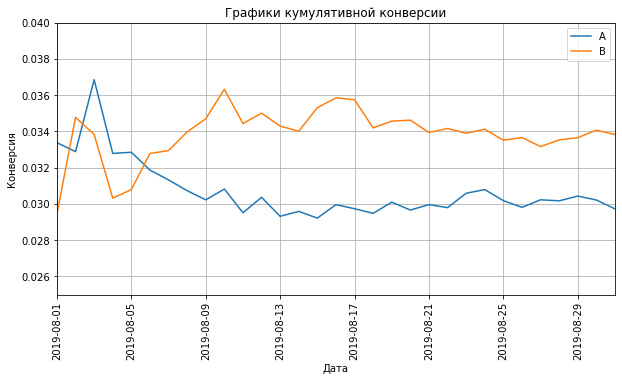

In [23]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(10,5))
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.xticks(rotation=90) 
plt.title('Графики кумулятивной конверсии')
plt.legend()
plt.grid(which='major')
# задаем масштаб осей
plt.axis(["2019-08-01", '2019-08-31', 0.025, 0.04]) 
plt.show()

В начале теста группа "А" имела большую конверсию, чем группа "В", но после 6 августа ситуация изменилась. В группе "А" конверсия снизилась, а в группе "В"  конверсия увеличилась и до конца теста осталась больше.

Построим график относительного различия кумулятивных конверсий:

(18109.0, 18139.0, -0.2, 0.25)

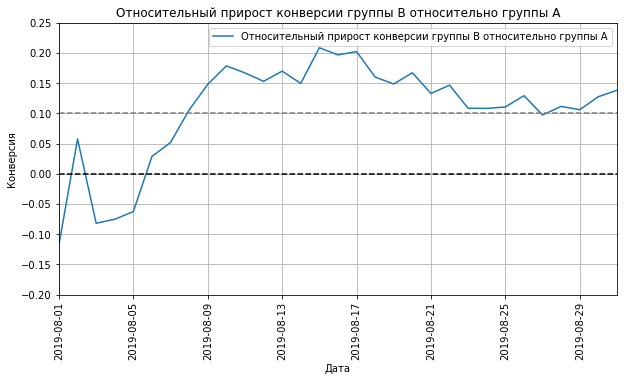

In [24]:
# собирем данные cumulativeDataA и cumulativeDataB в одну таблицус колонками date' и 'conversion'
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
         mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.xticks(rotation=90) 
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.legend()
plt.grid(which='major')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
# задаем масштаб осей
plt.axis(["2019-08-01", '2019-08-31', -0.2, 0.25]) 

После 6 августа наблюдаем как конверсия группы "В" увеличилась относительно конверсии группы "А", в пике превысив ее на 20%, затем наблюдаем снижение разницы конверсий  до  10%, но все же показатель группы "В" до конца теста остается выше. 
Стоит проанализировать аномалии, возможно, они изменят картину.

###  Исследование аномалий в данных

Ранее мы предположили, что данные содержат аномальные значения. Это могут быть либо чрезмерно большое количество заказов, либо очень дорогие одиночные покупки. Если такой дорогой заказ попадёт в одну из групп теста, он исказит результаты и сделает победителем ту группу, где оказался. При этом такие покупки — редкость, исключение, которое проявилось не из-за тестирования гипотезы, а случайно. Поищем такие заказы.

Для начала изучим график распределения числа заказов по пользователям:

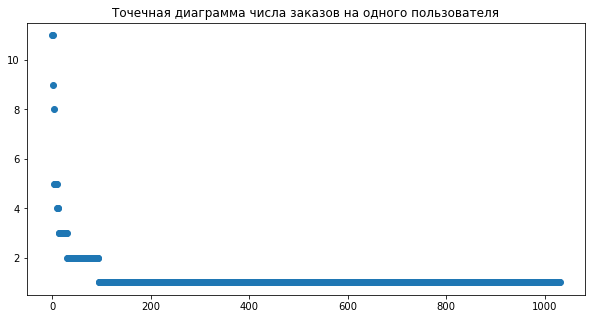

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


In [25]:
# сгруппируем пользователей по ID и посчитаем количество заказов
ordersByUsers = orders.groupby('userId', as_index = False).agg({'orderId':'nunique'}).sort_values(by='orderId', ascending = False)
ordersByUsers.columns = ['userId', 'orders']

plt.figure(figsize=(10,5))
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.show()
display(ordersByUsers.head(10))

Большинство покупателей заказывали только 1 раз. Клиентов совершивших 2 и более покупок немного. Посчитаем выборочные перцентили количества заказов на одного пользователя -  выберем границу для определения аномальных пользователей: 

In [26]:
percentiles = np.percentile(ordersByUsers['orders'], [95, 99])
print('Перцентили:\n95: {}\n99: {}'.format(percentiles[0],percentiles[1]))

Перцентили:
95: 2.0
99: 4.0


Да, видим, что только 5% пользователей делает больше 2х заказов. Аномальными будем считать 3 и более покупок.

Теперь посмотрим на  стоимость заказов. Построим точечную диаграму и посчитаем перцентили.

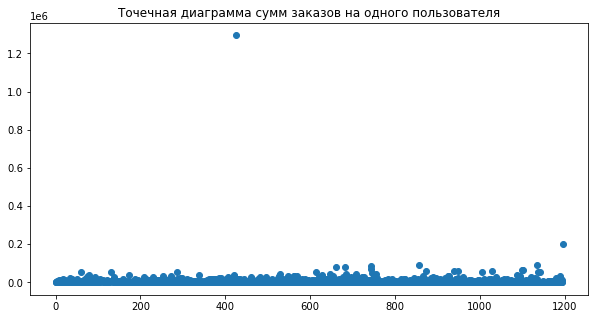

In [27]:
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечная диаграмма сумм заказов на одного пользователя')

plt.show()

Большого разброса стоимости заказов, при таком размере графика, не наблюдается. Но видим два сильно выбивающихся значения, которые уже повлияли на масштаб графика и наверняка повлияли на расчеты метрик.

In [28]:
# посмотрим строку с максимальным значением.
display(orders[orders.revenue.max() == orders['revenue']])

,orderId,userId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B


Вот и нашелся наш всплеск для группы "B" за 19 августа. Стоимость заказа почти 1,3 млн. Есть подозрение, что второе аномальное значение принадлежит группе "A" за 6 августа, но проверять его уже смысла нет. Теперь укрупним график и посмотим на разброс точек.

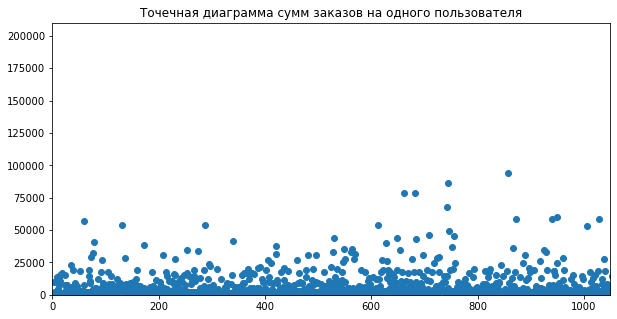

In [29]:
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечная диаграмма сумм заказов на одного пользователя')
plt.axis([0, 1050, 0, 210000])
plt.show()

По укрупненному графику разброс точек проявился сильнее. Большая часть заказов не превышает 25 тысяч. Много заказов видим в границах чека от 25 до 50 тысяч. Есть и единичные заказы стоимостью от 50 до 100 тысяч. Чтобы определить границу аномальных чеков так же посчитаем 95 и 99 перцентиль.

In [30]:
percentiles = np.percentile(orders['revenue'], [95, 99])
print('Перцентили:\n95: {:.0f}\n99: {:.0f}'.format(percentiles[0],percentiles[1]))

Перцентили:
95: 28000
99: 58233


Покупки дороже 28 тысяч совершает не более 5% пользователей и всего лишь 1% делает покупки дороже 58 тысяч. Этот 1% и будем считать аномальным. 

#### Промежуточный вывод

Мы построили и изучили по группам A/B графики кумулятивной выручки, кумулятивного среднего чека, кумулятивной конверсии, относительного изменения кумулятивной конверсии группы B к группе A. 

Нашли, что кумулятивная выручка увеличивается для обеих групп. Для группы "B" этот показатель увеличился и стал выше, чем у "А". В начале теста группа "А" имела большую конверсию, но после 6 августа ее конверсия снизилась, а в группе "В" наоборот конверсия увеличилась и до конца теста осталась больше. Нашли резкие изменения метрики различия средних чеков между группами A/B. Такая нестабильность указывает на присутствие аномальных значений в данных. Было решено посчитать 95 и 99 перцентили и определить какое количество заказов и какую сумму чека можно считать аномальными.

Аномальными признали 3 и более покупок и чеки на сумму более 58 тысяч.



### Статистическая значимость полученных данных

Чтобы принять решение по результатам A/B теста осталось проверить являются ли статистически значимыми полученные нами данные. Для этого посчитаем стат.значимость для необработанных -"сырых" данных и для данных из которых исключили аномальные значения- "очищенных".

Посчитаем:
- статистическую значимость различий в конверсии между группами по «сырым» данным, 
- статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным,
- статистическую значимость различий в конверсии между группами по «очищенным» данным,
- статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 



Считаем статистическую значимость различий в конверсии между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы:

**Нулевая гипотеза**: различий в конверсии между группами нет. 

**Альтернативная гипотеза**: различия в конверсии между группами есть.

В нашем случае есть большие выбросы, которые могут исказить общую картину. Алгебраические метрики здесь сработают плохо и логичнее будет применить непараметрический тест «U-критерий Манна-Уитни». 

Подготовим данные. 

In [31]:
# разбиваем количество посетителей из группы A по датам
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# создаем таблицу кумулятивного количества  посетителей из группы A по датам
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# разбиваем количество посетителей из группы B по датам
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# создаем таблицу кумулятивного количества  посетителей из группы B по датам
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# считаем количество заказов и суммарный доход за день для группы А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# создаем таблицу кумулятивного количества заказов и суммарный доход на каждый день для группы А
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]
# считаем количество заказов и суммарный доход за день для группы B
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# создаем таблицу кумулятивного количества заказов и суммарный доход на каждый день для группы B
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]
# собираем общую таблицу 
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
# проверяем
data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [32]:
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']
# Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
# Тем, кто ничего не заказал, будут соответствовать нули.
sampleA = pd.concat([ordersByUsersA['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
            name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
            name='orders')], axis=0)

Наконец Применим U-критерий Манна-Уитни. Выведем также значение относительного прироста конверсии группы B по формуле: конверсия группы B / конверсия группы A - 1. 

In [33]:
alpha = 0.05 # критический уровень статистической значимости для всех тестов в проекте
results = stats.mannwhitneyu(sampleA, sampleB)
print('P-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Различия в конверсии между группами есть.')
else:
    print('Отвергаем альтернативную гипотезу. Различий в конверсии между группами нет.')

display("Относительный прирост конверсии группы B : {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

P-value: 0.017
Отвергаем нулевую гипотезу. Различия в конверсии между группами есть.


'Относительный прирост конверсии группы B : 0.138'

Получили статистически значимую разницу конверсий между группами. По сырым данным прирост конверсии для группы "B" составил 13,8%.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.Сформулируем гипотезы:

**Нулевая гипотеза**: различий в среднем чеке заказа между группами нет.

**Альтернативная гипотеза**: различия в среднем чеке заказа между группами есть.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. И еще выведем относительные различия в среднем чеке между группами.

In [34]:
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print('P-value:  {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Различия в среднем чеке между группами есть.')
else:
    print('Отвергаем альтернативную гипотезу. Различий в среднем чеке между группами нет.')

print('Относительное различие в среднем чеке между группами: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()
                                                                             /orders[orders['group']=='A']['revenue'].mean()-1))

P-value:  0.729
Отвергаем альтернативную гипотезу. Различий в среднем чеке между группами нет.
Относительное различие в среднем чеке между группами: 0.259


По сырым данным не получилось отвергнуть нулевую гипотезу. P-value составил  0.729 и превысил критический уровень статистической значимости. 

Теперь проверим какие выводы можно сделать по чистым данным. Мы приняли за аномальных пользователей тех, кто совершил более 2х заказов или совершил заказ на сумму свыше 28 тысяч.

Приступаем к подготовке чистых данных. Сначала определим аномальные заказы, затем пользователей, совершивших эти заказы, и добавим их в список аномальных.

In [35]:
orders_95percentile = 2
Revenue_99percentile = 58000
# делаем срез пользователей с  числом заказов больше 2х
usersWithManyOrders = pd.concat([
        ordersByUsersA[ordersByUsersA['orders'] > orders_95percentile]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_95percentile]['userId'],
    ], axis=0)

# делаем срез пользователей совершивших заказы дороже 58 тысяч
usersWithExpensiveOrders = orders[orders['revenue'] > Revenue_99percentile]['userId']

# собираем их в одну таблицу,убираем дубликаты и сортируем
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
#проверочка
display(usersWithManyOrders.head())

print('Количество аномальных пользователей: {}'.format(len(abnormalUsers)))

18      199603092
23      237748145
68      611059232
146    1230306981
189    1614305549
Name: userId, dtype: int64

Количество аномальных пользователей: 31


Теперь создадим переменные sampleAFiltered и sampleBFiltered, в которых сохраним очищенные данные о заказах — не включающих аномальных пользователей.

In [36]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни к очищенным данным. И посчитаем прирост конверсии:

In [37]:
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)
print('P-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Различия в конверсии между группами есть.')
else:
    print('Отвергаем альтернативную гипотезу. Различий в конверсии между группами нет.')

print("Относительный прирост конверсии группы B : {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-value: 0.010
Отвергаем нулевую гипотезу. Различия в конверсии между группами есть.
Относительный прирост конверсии группы B : 0.174


По очищенным данным различия в конверсии также оказались статистически значимыми, но теперь прирост конверсии для группы B составляет 17,4%.

Посмотрим как удаление аномальных покупок сказалось на средних чеках по группам.

In [38]:
alpha = 0.05
# оставляем чеки группы А, убрав чеки аномальных пользователей
ordersCleanA =  orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue']
# оставляем чеки группы B, убрав чеки аномальных пользователей
ordersCleanB = orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue']


In [39]:
results = stats.mannwhitneyu(ordersCleanA, ordersCleanB)
print('P-value:  {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Различия в среднем чеке заказа между группами есть.')
else:
    print('Отвергаем альтернативную гипотезу. Различий в среднем чеке заказа между группами нет.')

print('Относительное различие в среднем чеке между группами: {0:.3f}'.format(ordersCleanB.mean()/ordersCleanA.mean()-1))

P-value:  0.798
Отвергаем альтернативную гипотезу. Различий в среднем чеке заказа между группами нет.
Относительное различие в среднем чеке между группами: -0.020


Как и по сырым данным получили, что по очищенным данным статистических различий в чеках групп A/B нет. Разница в чеках меньше 1%.

## Общий вывод



Задачей исследования было проанализировать результаты A/B теста и принять одно из трех возможных решений:
1. Остановить тест, зафиксировать победу одной из групп. 
2. Остановить тест, зафиксировать отсутствие различий между группами. 
3. Продолжить тест.

На 31.08.2019 в эксперименте приняло участие более 37 тысяч пользователей. В группу "А" попало 18736 пользователей, из них совершили хотя бы одну покупку 445 пользователя на общую сумму 3 364 656 д.е. В группу "B" попало 18916 пользователей, из них совершили хотя бы одну покупку 586 пользователей на общую сумму 5 068 972 д.е. Нашли 58 пользователей, которые попали в обе группы теста, их  менее 5% от общего числа. Стоило бы, конечно, удалить этих пользователей из наших двух таблиц с визитами и заказами, но таблица визитов не содержит id пользоватлей, только их количество.  Если мы уберем только совершенные ими заказы, то расчеты конверсии будут не верными. Поэтому оставили как есть, но стоит разобраться с настройками при проведении теста и выяснить причину.

Чтобы понять можно ли завершить тест мы исследовали графики кумулятивных показателей. Кумулятивная выручка увеличивается для обеих групп, как и должно быть. Для группы "B" этот показатель стабильно выше группы "А", но на графике были замечены сильные всплески. После 6 августа конверсия группы "В" увеличилась относительно конверсии группы "А", в пике превысив ее на 20%, затем наблюдается снижение разницы конверсий до 10%, но все же показатель группы "В" до конца теста остается выше. Значение среднего чека "B" резко подскочило после всплеска, но уже на следующий день отмечена тенденция к снижению показателя. Такая нестабильность указывает на присутствие аномальных значений в данных, наличие которых могло исказить общую картину и повлиять на результаты исследования.

Мы предположили, что данные содержат аномальные значения, которые искажают общую картину. Это могут быть либо чрезмерно большое количество заказов, либо очень дорогие одиночные покупки. Было решено посчитать 95 и 99 перцентили и определить какое количество заказов и какую сумму чека можно считать аномальными. Аномальными признали клиентов, совершивших 3 и более покупок и чеки на сумму более 58 тысяч.

Чтобы принять окончательное решение по результатам A/B теста посчитали стат.значимость для необработанных -"сырых" данных и для данных из которых исключили аномальные значения- "очищенных".

Были выдвинуты следующие пары гипотез:

**Нулевая гипотеза**: различий в конверсии между группами нет. **Альтернативная гипотеза**: различия в конверсии между группами есть.

**Нулевая гипотеза**: различий в среднем чеке заказа между группами нет. **Альтернативная гипотеза**: различия в среднем чеке заказа между группами есть.

Конверсия в обоих случаях оказалась статистически значимой. По "сырым" данным прирост конверсии для группы "B" составил 13,8%, по "очищеным" уже 17,4%. В среднем чеке для групп A/B статистичесих различий нет как по "сырым" данным, так и по "очищенным".

Учитывая статистически подтвержденное увеличение конверсии для группы "B" и изучив графики, на которых показатели группы "B" увеличились и зафиксировались выше показателей группы "А" принимаем решение: 
Остановить тест, зафиксировать победу группы "B". 